# Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.subplots as sp
from plotly.offline import init_notebook_mode, iplot
!pip install --upgrade "kaleido==0.1.*" #to output plotly plots as .png
init_notebook_mode(connected = True)

from google.cloud import bigquery


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 MB 18.7 MB/s eta 0:00:0000:0100:01


# Connect to BigQuery

In [3]:
# Connect to BQ
client = bigquery.Client()
reference_dataset = client.dataset('google_analytics_sample', project='bigquery-public-data')

Using Kaggle's public dataset BigQuery integration.


In [4]:
#tables are of format ga_sessions_20YYMMDD
#fetch tables and convert them to dataframe

test_table = client.get_table(reference_dataset.table('ga_sessions_20160801'))

test_df = client.list_rows(test_table, max_results=2).to_dataframe()

test_df

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,channelGrouping,socialEngagementType
0,NaN,1,1470046245,1470046245,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 17, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Firefox', 'browserVersion': 'not ...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",895954260133011192,None,Organic Search,Not Socially Engaged
1,NaN,1,1470084717,1470084717,20160801,"{'visits': 1, 'hits': 24, 'pageviews': 18, 'ti...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Internet Explorer', 'browserVersi...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 13, 'minu...",0288478011259077136,None,Direct,Not Socially Engaged


In [101]:
#Check table column schema for the device column. It translates to index = 12
print(test_table.schema[10].to_standard_sql(), end='\n')

name: "hits"
type {
  type_kind: ARRAY
  array_element_type {
    type_kind: STRUCT
    struct_type {
      fields {
        name: "hitNumber"
        type {
          type_kind: INT64
        }
      }
      fields {
        name: "time"
        type {
          type_kind: INT64
        }
      }
      fields {
        name: "hour"
        type {
          type_kind: INT64
        }
      }
      fields {
        name: "minute"
        type {
          type_kind: INT64
        }
      }
      fields {
        name: "isSecure"
        type {
          type_kind: BOOL
        }
      }
      fields {
        name: "isInteraction"
        type {
          type_kind: BOOL
        }
      }
      fields {
        name: "isEntrance"
        type {
          type_kind: BOOL
        }
      }
      fields {
        name: "isExit"
        type {
          type_kind: BOOL
        }
      }
      fields {
        name: "referer"
        type {
          type_kind: STRING
        }
      }
      

# Exploratory Data Analysis (EDA)

***Total Pageviews by Time***

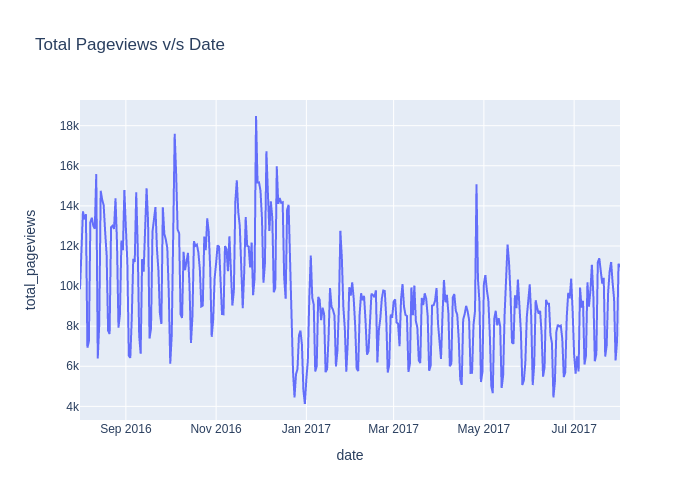

In [6]:
# Pageviews by Time

query = """
            SELECT 
                date, 
                SUM(totals.pageviews) as total_pageviews 
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
            WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            GROUP BY date
            ORDER BY date"""

df = client.query(query).result().to_dataframe()
df['date'] = pd.to_datetime(df['date'])

#VIZ

# Define the plot
fig = px.line(df, x='date', y='total_pageviews', title='Total Pageviews v/s Date')

#add axis labels
fig.update_xaxes(title_text='date')
fig.update_yaxes(title_text='total_pageviews')

# Show the interactive plot
fig.show(renderer = 'png')

***Pageviews by Channel***

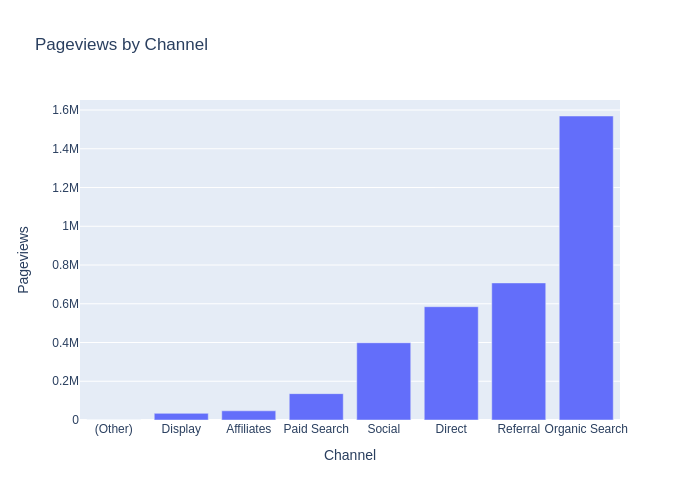

In [7]:
#Calculate total pageviews by channel
query = """
            SELECT 
                channelGrouping as channel_grouping, 
                SUM(totals.pageviews) as total_pageviews 
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
            WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            GROUP BY channelGrouping
            ORDER BY total_pageviews"""

df = client.query(query).result().to_dataframe()

#VIZ

#Define the plot
fig = px.bar(df, x = 'channel_grouping', y = 'total_pageviews', title = "Pageviews by Channel")

#add axis labels
fig.update_xaxes(title_text = 'Channel')
fig.update_yaxes(title_text = 'Pageviews')

fig.show(renderer = 'png')

***Transactions by Channel***


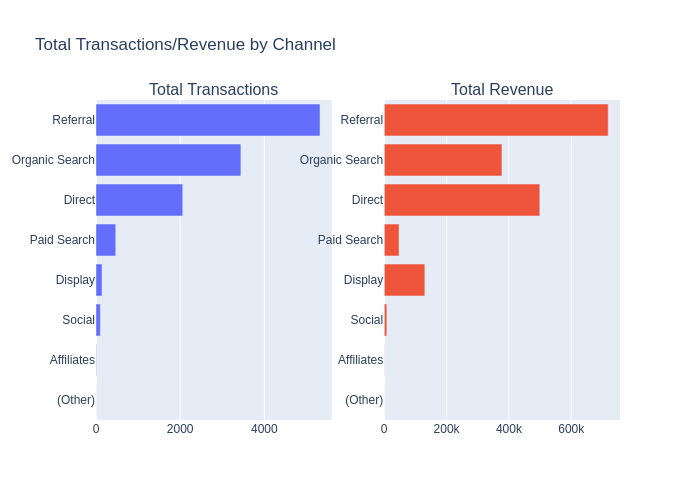

In [8]:
#Calculate total transactions and total revenue by channel
query = """
            SELECT 
                channelGrouping as channel_grouping, 
                COUNT(DISTINCT hits.transaction.transactionId) as total_transactions,
                SUM(hits.transaction.transactionRevenue)/1000000 as total_revenue
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*` as ga, UNNEST(ga.hits) as hits
            WHERE _TABLE_SUFFIX BETWEEN '20160801' AND '20170801'
            GROUP BY channelGrouping
            ORDER BY total_transactions"""

df = client.query(query).result().to_dataframe()
df

# VIZ

#split the canvas into one row and two columns
fig = sp.make_subplots(rows=1, cols=2, subplot_titles=['Total Transactions', 'Total Revenue'])

# Add the first bar plot
fig.add_trace(go.Bar(
    x=df['total_transactions'],
    y=df['channel_grouping'],
    orientation='h',
), row=1, col=1)

# Add the second bar plot
fig.add_trace(go.Bar(
    x=df['total_revenue'],
    y=df['channel_grouping'],
    orientation='h',
), row=1, col=2)

# Update layout
fig.update_layout(
    title='Total Transactions/Revenue by Channel',
    showlegend=False  
)

# Show the plot
fig.show(renderer = 'png')

***Top 10 URLs by no: of unique pageviews***

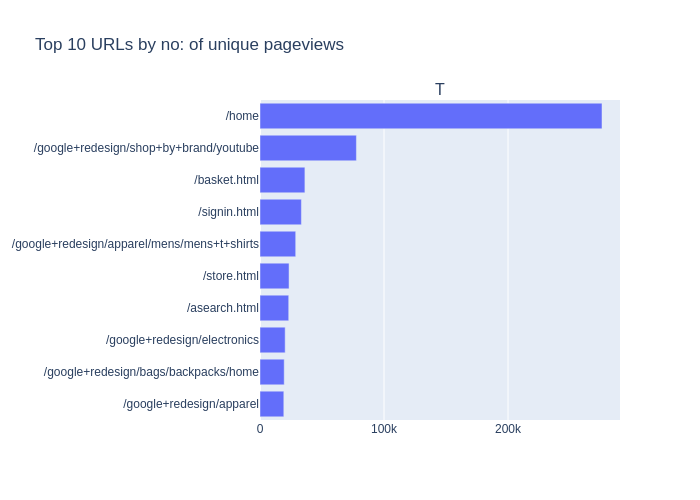

In [20]:
query = """
        SELECT fullVisitorId, date, hits.page.pagepath AS page
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        , UNNEST(hits) AS hits
        WHERE _TABLE_SUFFIX BETWEEN '20170101' AND '20170801'
        """
df = client.query(query).result().to_dataframe()
df = df.groupby(['fullVisitorId', 'date', 'page']).size().reset_index(name = 'count')
df['count'] = 1
df = df.groupby('page')['count'].sum().reset_index().sort_values(by = 'count', ascending = True)
df = df.tail(10)

#VIZ

#define the canvas
fig = sp.make_subplots(rows=1, cols=1, subplot_titles=['T'])

# Add the first bar plot
fig.add_trace(go.Bar(
    x=df['count'],
    y=df['page'],
    orientation='h',
), row=1, col=1)



# Update layout
fig.update_layout(
    title='Top 10 URLs by no: of unique pageviews',
    showlegend=False  
)

# Show the plot
fig.show(renderer = 'png')

***Average time Spent by an user on a page***

To calculate this metric, we need to calculate a few more metrics and it is not as straightforward as it sounds. 

**Time spent on a Non-Exit page**
Most pages in this website are non-exit pages meaning the user enters, interacts (maybe not) with the website and then moves to another page. The time at which an user enters a webpage is stored in hits.time variable. So to calculate the time spent on a non-exit page we basically need to subtract the hit.time of the non-exit page from the hit.time of the next hit/page the user enters. 

For example here the time a user spent on the /home page after entering at '0' was 11.724 - 0 = 11.724 seconds before moving to the ***/google+redesign/apparel/women+s/women+s+t+shirts*** page. However, an interesting thing to note is that the user exits the page at hitNumber = 4 or at ***/signin.html*** and that is the last thing the user does therefore the time when the last interaction started is also 151.277. Which means that the time spent by the user on this page was ***zero***

In [102]:
#Time spent on a Non-Exit page
query = """
                  SELECT
                    fullVisitorId,
                    visitStartTime,
                    hits.page.pagePath,
                    hits.isInteraction,
                    hits.hitNumber,
                    hits.type,
                    hits.isExit,
                    hits.time / 1000 AS hit_time,
                    MAX(IF(hits.isInteraction IS NOT NULL,
                        hits.time / 1000,
                        0)) OVER (PARTITION BY fullVisitorId, visitStartTime) AS last_interaction
                  FROM
                    `bigquery-public-data.google_analytics_sample.ga_sessions_20160801` AS GA,
                    UNNEST(GA.hits) AS hits            
        """
df = client.query(query).result().to_dataframe()

df[df['fullVisitorId'] == '0957124016598662665']

,fullVisitorId,visitStartTime,pagePath,isInteraction,hitNumber,type,isExit,hit_time,last_interaction
5967,0957124016598662665,1470095705,/home,True,1,PAGE,None,0.000,151.277
5968,0957124016598662665,1470095705,/google+redesign/apparel/women+s/women+s+t+shirts,True,2,PAGE,None,11.724,151.277
5969,0957124016598662665,1470095705,/home,True,3,PAGE,None,144.772,151.277
5970,0957124016598662665,1470095705,/signin.html,True,4,PAGE,True,151.277,151.277


**Time spent on an Exit page**

This is a case of a session where there the user exits at the apparel page. One important thing to note here is that the hit_time for the exit page with hit.type = 'Event' means that that is the first time the user viewed the page. Next is the hit_time for the last interaction event which is also on the same page. The difference between the hit_time of the last interaction and the hit_time of the exit is what gives us the time that the user spent on this page. 

NOTE: Though we are using the phrase 'hit time of the exit' it just means the time when the user entered the 'exit' page. The sequence is basically the user enters the page at a timestamp of 41.17 and then makes an interaction at 98.15 and then leaves. The time spent on this page is just the difference of these two values. 

In [94]:
query = """
                  SELECT
                    fullVisitorId,
                    visitStartTime,
                    hits.page.pagePath,
                    hits.isInteraction,
                    hits.type,
                    hits.isExit,
                    hits.time / 1000 AS hit_time,
                    MAX(IF(hits.isInteraction IS NOT NULL,
                        hits.time / 1000,
                        0)) OVER (PARTITION BY fullVisitorId, visitStartTime) AS last_interaction
                  FROM
                    `bigquery-public-data.google_analytics_sample.ga_sessions_20160801` AS GA,
                    UNNEST(GA.hits) AS hits            
        """
df = client.query(query).result().to_dataframe()

df[df['fullVisitorId'] == '7666394839176567102']

,fullVisitorId,visitStartTime,pagePath,isInteraction,type,isExit,hit_time,last_interaction
1175,7666394839176567102,1470115733,/home,True,PAGE,None,0.000,98.15
1176,7666394839176567102,1470115733,/home,True,EVENT,None,34.141,98.15
1177,7666394839176567102,1470115733,/google+redesign/apparel,True,PAGE,True,41.671,98.15
1178,7666394839176567102,1470115733,/google+redesign/apparel,True,EVENT,None,98.150,98.15


In [5]:
#average time spent on each page (From 2016-08-01 to 2017-08-01)
#This dataframe gives the average time spent on each page for each day for the above date range mentioned

query = """
SELECT
  pagePath,
  date,
  pageviews,
  exits,
  total_time_on_page,
  CASE
    WHEN pageviews = exits THEN 0
    ELSE total_time_on_page / (pageviews - exits)
  END AS avg_time_on_page
FROM (
  SELECT
    pagePath,
    date,
    COUNT(*) AS pageviews,
    SUM(IF(isExit IS NOT NULL,
        1,
        0)) AS exits,
    SUM(time_on_page) AS total_time_on_page
  FROM (
    SELECT
      fullVisitorId,
      date,
      visitStartTime,
      pagePath,
      hit_time,
      type,
      isExit,
      CASE
        WHEN isExit IS NOT NULL THEN last_interaction - hit_time
        ELSE next_pageview - hit_time
      END AS time_on_page
    FROM (
      SELECT
        fullVisitorId,
        date,
        visitStartTime,
        pagePath,
        hit_time,
        type,
        isExit,
        last_interaction,
        LEAD(hit_time) OVER (PARTITION BY fullVisitorId, visitStartTime ORDER BY hit_time) AS next_pageview
      FROM (
        SELECT
          fullVisitorId,
          date,
          visitStartTime,
          pagePath,
          hit_time,
          type,
          isExit,
          last_interaction
        FROM (
          SELECT
            fullVisitorId,
            date,
            visitStartTime,
            hits.page.pagePath,
            hits.type,
            hits.isExit,
            hits.time / 1000 AS hit_time,
            MAX(IF(hits.isInteraction IS NOT NULL,
                hits.time / 1000,
                0)) OVER (PARTITION BY fullVisitorId, visitStartTime) AS last_interaction
          FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*` AS GA,
            UNNEST(GA.hits) AS hits
            WHERE _TABLE_SUFFIX BETWEEN '20170101' AND '20170801')
        WHERE
          type = 'PAGE')))
  GROUP BY pagePath, date)
ORDER BY
  pageviews DESC
        """
df = client.query(query).result().to_dataframe()
df

,pagePath,date,pageviews,exits,total_time_on_page,avg_time_on_page
0,/home,20170426,3431,1309,116048.655,54.688339
1,/home,20170323,3155,1480,105994.805,63.280481
2,/home,20170124,3127,1467,80310.020,48.379530
3,/home,20170517,2900,1014,117515.392,62.309328
4,/home,20170330,2856,1208,75962.299,46.093628
...,...,...,...,...,...,...
65736,/google+redesign/drinkware/tumblers/24oz+conti...,20170105,1,1,0.000,0.000000
65737,/google+redesign/apparel/men+s+google+lightwei...,20170527,1,0,23.696,23.696000
65738,/google+redesign/office/notebooks+journals/and...,20170723,1,0,21.119,21.119000
65739,/google+redesign/office/notebooks+journals/and...,20170723,1,0,43.899,43.899000


In [6]:
#Obtain the top 10 pages where max time was spent on average

df_average = df.groupby('pagePath')['pageviews'].mean().reset_index().sort_values(by = 'pageviews', ascending = False)

df_average.head(10)

,pagePath,pageviews
1861,/home,2101.788732
3,/basket.html,495.751174
1829,/google+redesign/shop+by+brand/youtube,476.746479
840,/google+redesign/apparel/mens/mens+t+shirts,270.126761
1914,/signin.html,252.708920
2045,/store.html,169.422535
0,/asearch.html,165.384977
417,/google+redesign/apparel/men++s/men++s+outerwear,139.877551
202,/google+redesign/apparel,123.774648
1298,/google+redesign/electronics,118.042254


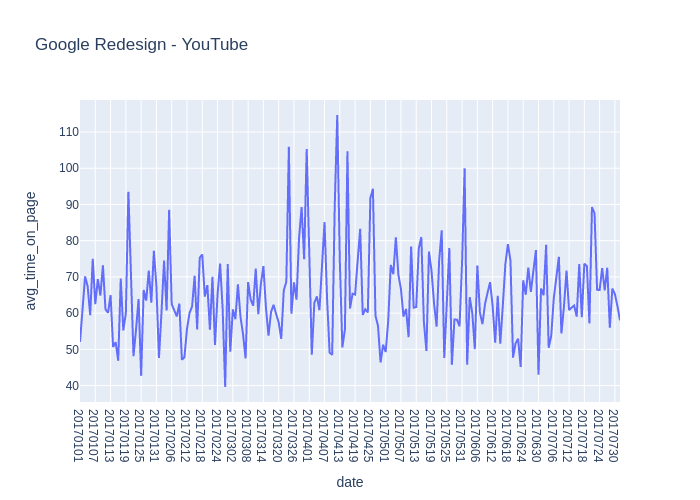

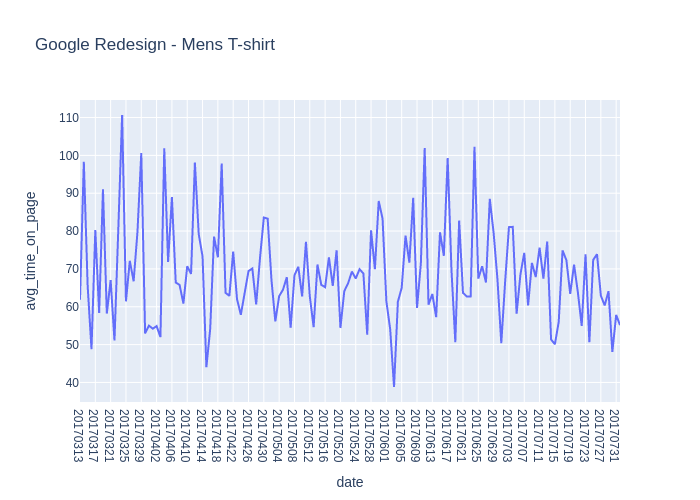

In [9]:
#VIZ

import plotly.express as px
import pandas as pd

# load data
google_redesign_youtube = df.copy()
google_redesign_youtube['date'] = pd.to_datetime(google_redesign_youtube['date'], format='%Y%m%d')
google_redesign_youtube = df[df['pagePath'] == '/google+redesign/shop+by+brand/youtube'] #https://shop.googlemerchandisestore.com/Google+Redesign/Shop+by+Brand/YouTube
google_redesign_youtube = google_redesign_youtube.sort_values(by = 'date', ascending = True)

google_redesign_mens_tshirt = df.copy()
google_redesign_mens_tshirt['date'] = pd.to_datetime(google_redesign_youtube['date'], format='%Y%m%d')
google_redesign_mens_tshirt = df[df['pagePath'] == '/google+redesign/apparel/mens/mens+t+shirts'] #https://shop.googlemerchandisestore.com/Google+Redesign/Shop+by+Brand/YouTube
google_redesign_mens_tshirt = google_redesign_mens_tshirt.sort_values(by = 'date', ascending = True)

# Creating a line chart using Plotly Express
fig1 = px.line(google_redesign_youtube, x='date', y='avg_time_on_page', title='Google Redesign - YouTube')
fig2 = px.line(google_redesign_mens_tshirt, x='date', y='avg_time_on_page', title='Google Redesign - Mens T-shirt')

import kaleido

# Show the plot
fig1.show(renderer = 'png')
fig2.show(renderer = 'png')


# ---------------------

In [2]:
import bq_helper
from bq_helper import BigQueryHelper
google_analytics = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="data:google_analytics_sample")

Using Kaggle's public dataset BigQuery integration.


In [3]:
bq_assistant = BigQueryHelper("bigquery-public-data", "google_analytics_sample")

Using Kaggle's public dataset BigQuery integration.


# **Main Query**

In [6]:
#MAIN QUERY
main_query = """SELECT 
                   session_id,
                   session_bounce_count
                   channel_grouping,
                   page_url,
                   hit_type,
                   event_action,
                   event_value,
                   hit_start_time,
                   interaction_hit_flag,
                   entrance_flag,
                   exit_flag,
                   product_name,
                   transaction_id,
                   transaction_sales_amount,
                   transaction_currency_code,
                   product_array.productSKU as product_sku,
                   product_array.v2ProductName as product_name,
                   product_array.productQuantity as product_quantity,
                   ROUND(product_array.productPrice/1000000,2) as product_price,
                   ROUND(product_array.productRevenue/1000000,2) as product_revenue
            FROM
            (SELECT date, 
                   fullVisitorId as session_id,
                   channelGrouping as channel_grouping,
                   totals.bounces as session_bounce_count,
                   hits.page.pagePath as page_url,
                   hits.type as hit_type,
                   hits.eventInfo.eventAction as event_action,
                   hits.eventInfo.eventValue as event_value,
                   hits.time as hit_start_time,
                   hits.isInteraction as interaction_hit_flag,
                   hits.isEntrance as entrance_flag,
                   hits.isExit as exit_flag,
                   hits.item.productName as product_name,
                   hits.transaction.transactionID as transaction_id,
                   hits.product as product_array,
                   ROUND(hits.transaction.transactionRevenue/1000000,2) as transaction_sales_amount,
                   hits.transaction.currencyCode as transaction_currency_code
            FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20160801` as GA,
            UNNEST(GA.hits) as hits
            ORDER BY session_id, hit_start_time ASC) as t CROSS JOIN UNNEST(t.product_array) as product_array;"""

main_query = google_analytics.query_to_pandas_safe(main_query)

main_query.head(5)

,session_id,channel_grouping,page_url,hit_type,event_action,event_value,hit_start_time,interaction_hit_flag,entrance_flag,exit_flag,product_name,transaction_id,transaction_sales_amount,transaction_currency_code,product_sku,product_name_1,product_quantity,product_price,product_revenue
0,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEGHPA002910,Google Trucker Hat,NaN,28.99,NaN
1,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEYHPA003510,YouTube Trucker Hat,NaN,30.99,NaN
2,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEGAAX0104,Google Men's 100% Cotton Short Sleeve Hero Tee...,NaN,16.99,NaN
3,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEGAAX0105,Google Men's 100% Cotton Short Sleeve Hero Tee...,NaN,16.99,NaN
4,000722514342430295,NaN,/google+redesign/apparel,PAGE,None,NaN,18101,True,None,None,None,None,NaN,USD,GGOEGAAX0107,Google Men's 100% Cotton Short Sleeve Hero Tee...,NaN,16.99,NaN


# Metric Calculations

**Datetime Generator**

In [7]:
#Generate the list of dates from 2016-08-01 to 2017-08-01

from datetime import datetime, timedelta

# Start and end dates
start_date_str = "2016-08-01"
end_date_str = "2017-08-01"

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

# Initialize an empty list to store dates
date_list = []

# Populate the list with dates
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date.strftime("%Y%m%d"))
    current_date += timedelta(days=1)
    

**Conversion Rate**

In [8]:
#Conversion Rate
df = main_query.groupby('session_id')['product_revenue'].sum().reset_index().sort_values(by = 'product_revenue', ascending = False)

total_sessions = len(df)
sessions_w_transactions = len(df.query('product_revenue!=0'))
conversion_pct = round((sessions_w_transactions / total_sessions) * 100,2)

print("Comversion Rate: " + str(conversion_pct) + " %")

Comversion Rate: 3.83 %


**Bounce Rate**

In [2]:
#Generate the list of sessions and bounces for the whole 365 days from 08/2016 - 08/2017
full_date_list = []
total_sessions_list = []
sessions_with_bounces_list = []

for i in date_list:  
    table_name = 'bigquery-public-data.google_analytics_sample.ga_sessions_' + str(i)
    query = f""" SELECT
                    CONCAT(fullVisitorId,visitId) as session_id,
                    sum(totals.bounces) as total_bounces_this_session
                FROM
                    `{table_name}` AS GA
                GROUP BY session_id
                ORDER BY total_bounces_this_session DESC"""

    total_sessions = google_analytics.query_to_pandas_safe(query)


    sessions_with_bounces = total_sessions[total_sessions['total_bounces_this_session']>0]
    bounce_rate = round((len(sessions_with_bounces) / len(total_sessions))*100,2)
    
    #add values to the list
    full_date_list.append(datetime.strptime(i, "%Y%m%d"))
    total_sessions_list.append(len(total_sessions))
    sessions_with_bounces_list.append(len(sessions_with_bounces))

df = pd.DataFrame()
df['full_date'] = full_date_list
df['total_sessions'] = total_sessions_list
df['sessions_with_bounces'] = sessions_with_bounces_list

#Extract month and year from the date field
df['month'] = df['full_date'].dt.month
df['year'] = df['full_date'].dt.year

#group bounces and sessions by MM-YY
df1 = df.groupby(['month', 'year'])[['total_sessions', 'sessions_with_bounces']].sum().reset_index()
df1 = df1.sort_values(by = ['year','month'], ascending = True)
df1['bounce_rate_pct'] = round((df1['sessions_with_bounces'] / df1 ['total_sessions']) * 100,2)

NameError: name 'date_list' is not defined

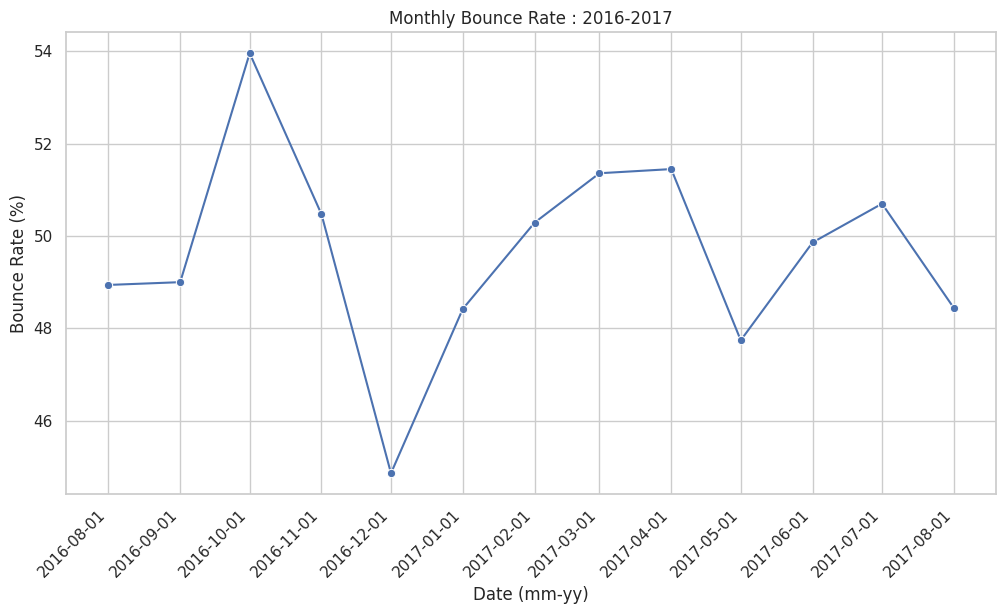

In [142]:
#Visualize the Bounce Rate on a time-series plot

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df1['date'] = pd.to_datetime(df1[['year', 'month']].assign(day=1))

# Sort the DataFrame by the datetime column
df1 = df1.sort_values('date')

# Create a time series plot using Seaborn
sns.set(style="whitegrid")  
plt.figure(figsize=(12, 6))  

# Plot the time series
sns.lineplot(x='date', y='bounce_rate_pct', data=df1, marker='o')

# Format the x-axis labels as 'mm-yy'
plt.xticks(rotation=45, ha='right', ticks=df1['date'])
plt.xlabel('Date (mm-yy)')
plt.ylabel('Bounce Rate (%)')
plt.title('Monthly Bounce Rate : 2016-2017')

plt.show()